In [2]:
import glob

import tensorflow as tf

from tensorflow.python.summary.summary_iterator import summary_iterator
from tensorflow.python.framework import tensor_util

from matplotlib import pyplot as plt
import yaml

import itertools
import numpy as np
import pandas as pd

In [3]:
def get_summary_files_from_dirs(dirs):
    files = []
    for d in dirs:
        files.extend(glob.glob(f"{d}/*/summary.yml"))
    
    return files

files = get_summary_files_from_dirs(["../artifacts-server/mnist--various-opts-M1"])
len(files)

40

In [4]:
files

['../artifacts-server/mnist--various-opts-M1/vdb-mnist--2019-11-25--17-46-49/summary.yml',
 '../artifacts-server/mnist--various-opts-M1/vdb-mnist--2019-11-26--00-40-34/summary.yml',
 '../artifacts-server/mnist--various-opts-M1/vdb-mnist--2019-11-25--17-46-46/summary.yml',
 '../artifacts-server/mnist--various-opts-M1/vdb-mnist--2019-11-26--07-37-55/summary.yml',
 '../artifacts-server/mnist--various-opts-M1/vdb-mnist--2019-11-26--09-30-08-925070/summary.yml',
 '../artifacts-server/mnist--various-opts-M1/vdb-mnist--2019-11-26--12-10-41-823999/summary.yml',
 '../artifacts-server/mnist--various-opts-M1/vdb-mnist--2019-11-25--23-44-36/summary.yml',
 '../artifacts-server/mnist--various-opts-M1/vdb-mnist--2019-11-25--22-49-18/summary.yml',
 '../artifacts-server/mnist--various-opts-M1/vdb-mnist--2019-11-26--09-27-16-207667/summary.yml',
 '../artifacts-server/mnist--various-opts-M1/vdb-mnist--2019-11-26--12-10-36-984242/summary.yml',
 '../artifacts-server/mnist--various-opts-M1/vdb-mnist--2019-1

In [5]:
def read_summary(fp):
    with open(fp, "r") as fh:
        summary = yaml.safe_load(fh)
        
    for s, v in summary['metrics'].items():
        for kk, vv in v.items():
            summary[f"metrics:{s}:{kk}"] = vv
            
    del summary['metrics']
    summary['filename'] = fp.split("/")[-2]

    
    return summary

read_summary(files[0])

{'M': 1,
 'beta': 0.001,
 'dataset': 'mnist',
 'epoch': 200,
 'lr': 0.0001,
 'model': 'vdb/e1:1024|e2:1024|z:256',
 'strategy': 'seq/d:5|e:1',
 'metrics:test:I_XZ': 23.959278106689453,
 'metrics:test:I_YZ': 3.1783642768859863,
 'metrics:test:accuracy_L1': 0.9808002710342407,
 'metrics:test:accuracy_L12': 0.9843003153800964,
 'metrics:test:loss': 0.16752313077449799,
 'metrics:train:I_XZ': 24.565067291259766,
 'metrics:train:I_YZ': 3.3177170753479004,
 'metrics:train:accuracy_L1': 0.9995665550231934,
 'metrics:train:accuracy_L12': 1.0,
 'metrics:train:loss': 0.028775587677955627,
 'filename': 'vdb-mnist--2019-11-25--17-46-49'}

In [6]:
def get_experiment_df(dirs):
    files = get_summary_files_from_dirs(dirs)
    
    
    df = pd.DataFrame([read_summary(f) for f in files])
    df["metrics:train:error_L1"] =  1 - df["metrics:train:accuracy_L1"]
    df["metrics:test:error_L1"] =  1 - df["metrics:test:accuracy_L1"]
    df["metrics:train:error_L12"] =  1 - df["metrics:train:accuracy_L12"]
    df["metrics:test:error_L12"] =  1 - df["metrics:test:accuracy_L12"]
    df['_key'] = "M=" + df.M.map(lambda m: "%02d" % m) + "::beta=" + df.beta.map(lambda b: "%0.0e" % b) \
        +  "::strategy="+df.strategy 
    return df

In [7]:
df_mnist_exp = get_experiment_df(
    [
        "../artifacts-server/mnist--various-opts-M*",
    ]
)
print("total records: ", len(df_mnist_exp))
df_mnist_exp[:3]

total records:  160


,M,beta,dataset,epoch,filename,lr,metrics:test:I_XZ,metrics:test:I_YZ,metrics:test:accuracy_L1,metrics:test:accuracy_L12,...,metrics:train:accuracy_L1,metrics:train:accuracy_L12,metrics:train:loss,model,strategy,metrics:train:error_L1,metrics:test:error_L1,metrics:train:error_L12,metrics:test:error_L12,_key
0,3,0.00001,mnist,200,vdb-mnist--2019-11-26--23-55-12-494281,0.0001,83.182648,3.241007,0.9858,0.9859,...,1.000000,1.000000,0.001091,vdb/e1:1024|e2:1024|z:256,seq/d:20|e:1,0.000000,0.0142,0.000000,0.0141,M=03::beta=1e-05::strategy=seq/d:20|e:1
1,3,0.00001,mnist,200,vdb-mnist--2019-11-26--09-22-29-355240,0.0001,94.631744,3.180870,0.9842,0.9856,...,0.999983,1.000000,0.001536,vdb/e1:1024|e2:1024|z:256,oneshot,0.000017,0.0158,0.000000,0.0144,M=03::beta=1e-05::strategy=oneshot
2,3,0.00001,mnist,200,vdb-mnist--2019-11-26--10-51-02-930612,0.0001,98.955956,3.211002,0.9861,0.9858,...,0.999983,0.999983,0.002424,vdb/e1:1024|e2:1024|z:256,seq/d:5|e:1,0.000017,0.0139,0.000017,0.0142,M=03::beta=1e-05::strategy=seq/d:5|e:1


In [8]:
df_mnist_exp.groupby("_key")["M"].count()

_key
M=01::beta=1e-03::strategy=oneshot         5
M=01::beta=1e-03::strategy=seq/d:10|e:1    5
M=01::beta=1e-03::strategy=seq/d:20|e:1    5
M=01::beta=1e-03::strategy=seq/d:5|e:1     5
M=01::beta=1e-05::strategy=oneshot         5
M=01::beta=1e-05::strategy=seq/d:10|e:1    5
M=01::beta=1e-05::strategy=seq/d:20|e:1    5
M=01::beta=1e-05::strategy=seq/d:5|e:1     5
M=03::beta=1e-03::strategy=oneshot         5
M=03::beta=1e-03::strategy=seq/d:10|e:1    5
M=03::beta=1e-03::strategy=seq/d:20|e:1    5
M=03::beta=1e-03::strategy=seq/d:5|e:1     5
M=03::beta=1e-05::strategy=oneshot         5
M=03::beta=1e-05::strategy=seq/d:10|e:1    5
M=03::beta=1e-05::strategy=seq/d:20|e:1    5
M=03::beta=1e-05::strategy=seq/d:5|e:1     5
M=06::beta=1e-03::strategy=oneshot         5
M=06::beta=1e-03::strategy=seq/d:10|e:1    5
M=06::beta=1e-03::strategy=seq/d:20|e:1    5
M=06::beta=1e-03::strategy=seq/d:5|e:1     5
M=06::beta=1e-05::strategy=oneshot         5
M=06::beta=1e-05::strategy=seq/d:10|e:1    5
M=06:

In [10]:
def label_alias(M, label):
    if label == "I_XZ":
        return "$I(X; Z)$"
    elif label == "I_YZ":
        if M == 1:
            return "$I(Y; Z)$"
        else:
            return "$J(Y; Z)$"
    else:
        return label

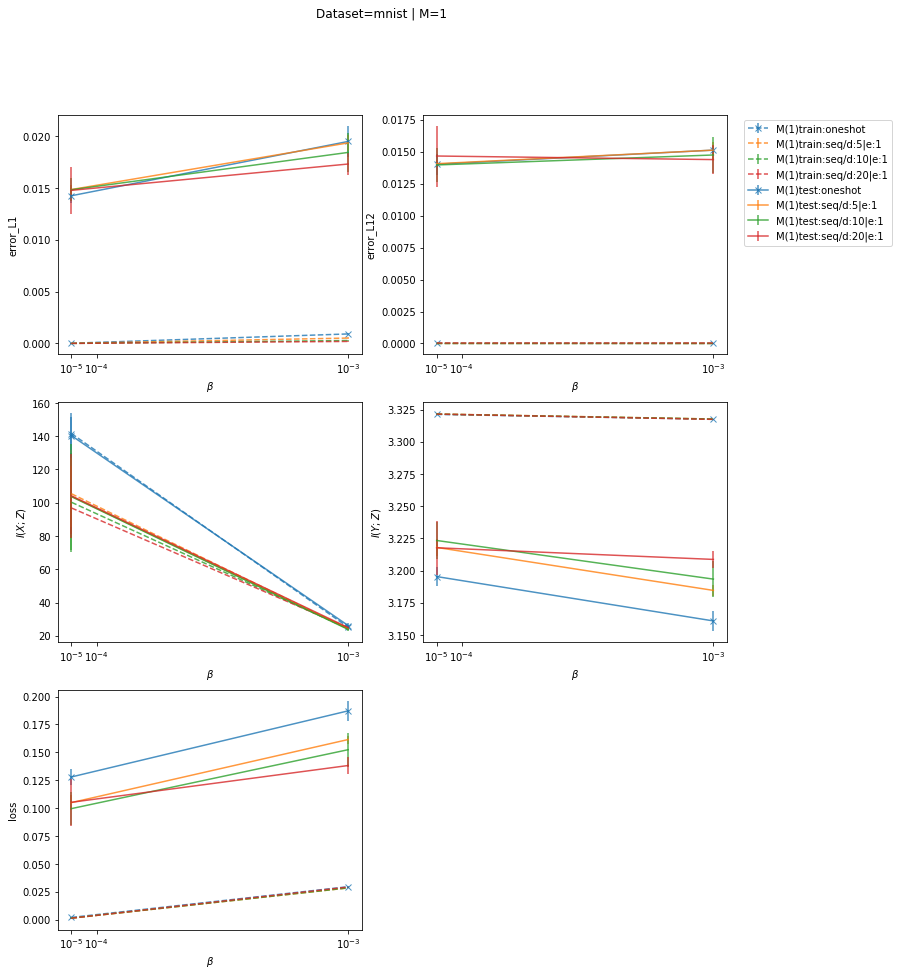

In [18]:
agg_funcs = ['mean','std']

def marker(s, strategy, M):
    if M==1 and strategy=="oneshot":
        return "x" 
#     else:
#         return "o" if s == "train" else "D"

def plot(df, models, sets=["train", "test"], metrics=["error_L1", "error_L12", "I_XZ", "I_YZ", "loss"]):
    cm = plt.get_cmap('tab10')
    
    kmetrics = map(lambda x: "metrics:%s:%s" % x, itertools.product(sets, metrics))

    agg_dict = dict(list(map(lambda k: (k, agg_funcs), kmetrics)))
    
    data = dict()
    
    maj_M = 0
    for mm in models:
        M, strategy =  mm.split("-")
        M = int(M[1:])
        maj_M = M
        df_select = df[(df.M == M) & (df.strategy == strategy)].groupby("beta") \
            .agg(agg_dict) 
    
        data[mm] = df_select



    plt.figure(figsize=(12, 15))
    for k, metric in enumerate(metrics):
        plt.subplot(3, 2, k+1)
        for s in sets:
            for i, mm in enumerate(models):
                M, strategy =  mm.split("-")
                M = int(M[1:])

                color = cm.colors[i]
                df_select = data[mm]
                plt.errorbar(
                    df_select.index.values,
                    df_select[f"metrics:{s}:{metric}"]['mean'].values, 
                    yerr=df_select[f"metrics:{s}:{metric}"]['std'].values, 
                    marker=marker(s, strategy, M),
                    label=f"M({M}){s}:{strategy}",
                    alpha=0.8,
                    color=color,
                    ls = "--" if s == "train" else "-"
                )

        plt.ylabel(label_alias(M, metric))
        plt.xlabel(r"$\beta$")
        plt.xticks([1e-5, 1e-4, 1e-3], ["$10^{-5}$", "$10^{-4}$", "$10^{-3}$"])
        if k == 1:

            lgd = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    dataset = df.dataset.values[0]
    plt.suptitle("Dataset=%s | M=%d" % (dataset, maj_M))
    plt.savefig("./figures/ib-curves/%s-summary-M%d.pdf" % (dataset, M), bbox_extra_artists=(lgd,), bbox_inches='tight')




plot(df_mnist_exp,
     sets=[
         "train",
         "test",
     ],
     models=[
        "M1-oneshot",
        "M1-seq/d:5|e:1",
        "M1-seq/d:10|e:1",
        "M1-seq/d:20|e:1"
    ]
)

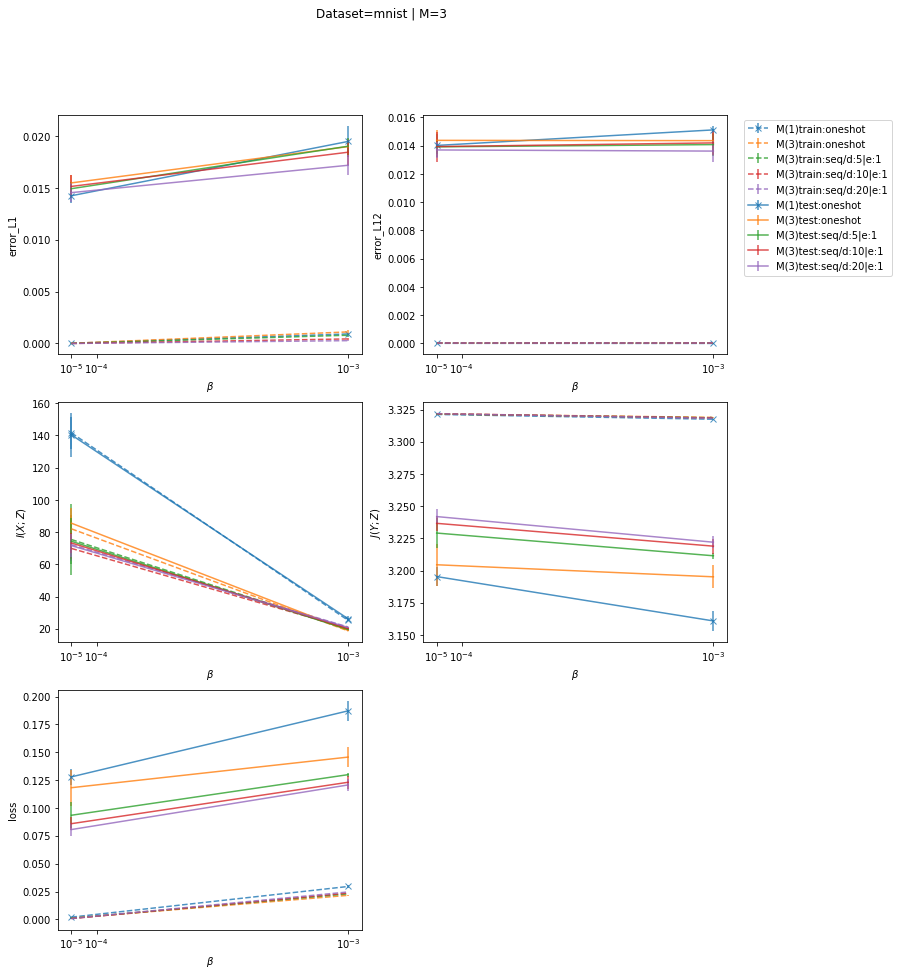

In [19]:
plot(df_mnist_exp,
     sets=[
         "train",
         "test",
     ],
     models=[
        "M1-oneshot",
        "M3-oneshot",
        "M3-seq/d:5|e:1",
        "M3-seq/d:10|e:1",
        "M3-seq/d:20|e:1"
    ]
)

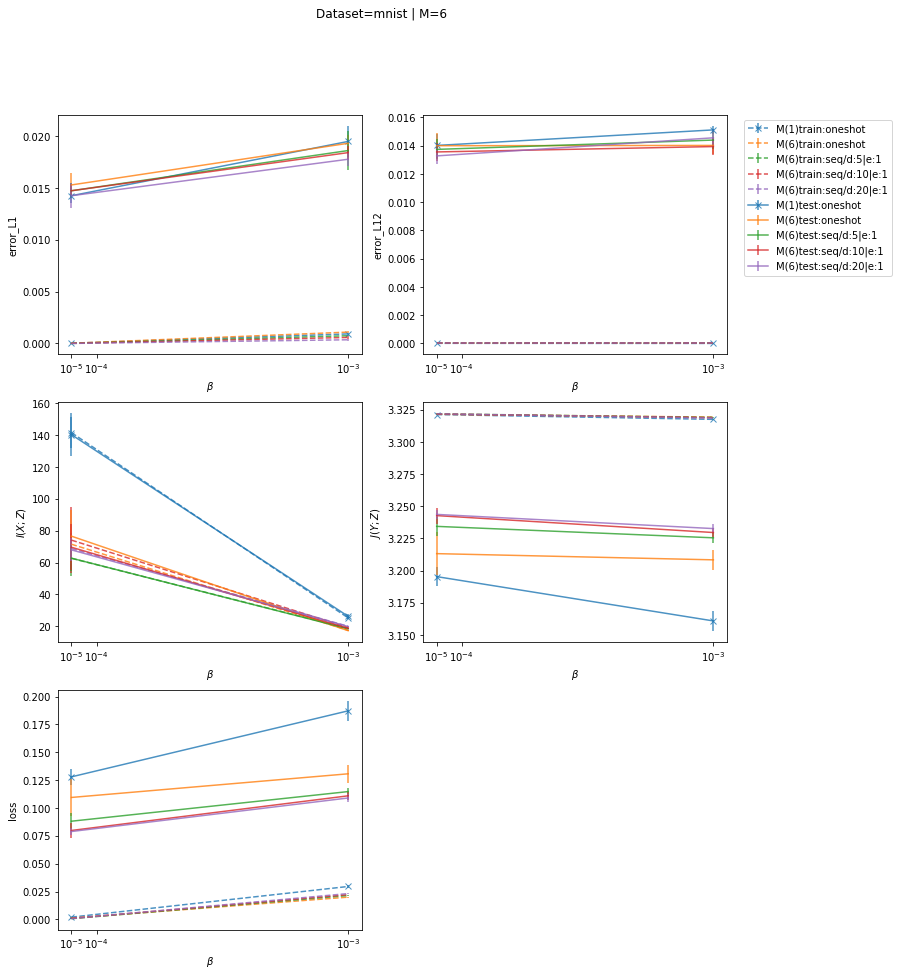

In [20]:
plot(df_mnist_exp,
     sets=[
         "train",
         "test",
     ],
     models=[
        "M1-oneshot",
        "M6-oneshot",
        "M6-seq/d:5|e:1",
        "M6-seq/d:10|e:1",
        "M6-seq/d:20|e:1"
    ]
)

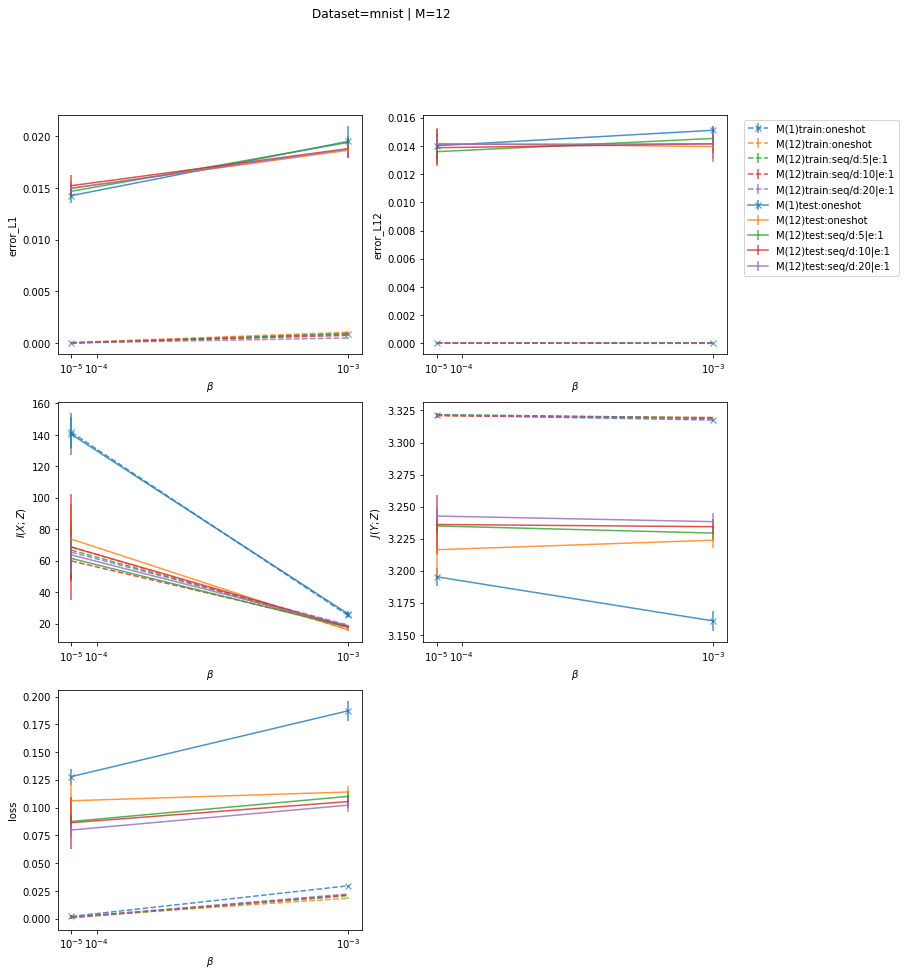

In [21]:
plot(df_mnist_exp,
     sets=[
         "train",
         "test",
     ],
     models=[
        "M1-oneshot",
        "M12-oneshot",
        "M12-seq/d:5|e:1",
        "M12-seq/d:10|e:1",
        "M12-seq/d:20|e:1"
    ]
)